## Forecast Apple daily stock return using a GARCH model.
Source: Yahoo Finance

Select GARCH model (ARCH, GARCH-M, IGARCH, EGARCH, TARCH, multivariate GARCH etc). Explain your choice.

Forecast next period daily return (t+1) using the chosen model. Select the timeframe in the analysis. Provide charts and comments.

In [493]:
# Load necessary libraries
library(quantmod)
library(ggplot2)
library(tseries)
library(rugarch)
library(lmtest)
library(moments)

In [350]:
# Download Apple data from Yahoo Finance
getSymbols("AAPL", src = "yahoo", from = '2000-01-01', to = '2019-04-01', getSymbols.yahoo.warning=FALSE)

# Show first few rows from the dataset
head(AAPL)

[1] "AAPL"

           AAPL.Open AAPL.High AAPL.Low AAPL.Close AAPL.Volume AAPL.Adjusted
2000-01-03  3.745536  4.017857 3.631696   3.997768   133949200      2.665724
2000-01-04  3.866071  3.950893 3.613839   3.660714   128094400      2.440975
2000-01-05  3.705357  3.948661 3.678571   3.714286   194580400      2.476697
2000-01-06  3.790179  3.821429 3.392857   3.392857   191993200      2.262367
2000-01-07  3.446429  3.607143 3.410714   3.553571   115183600      2.369532
2000-01-10  3.642857  3.651786 3.383929   3.491071   126266000      2.327857

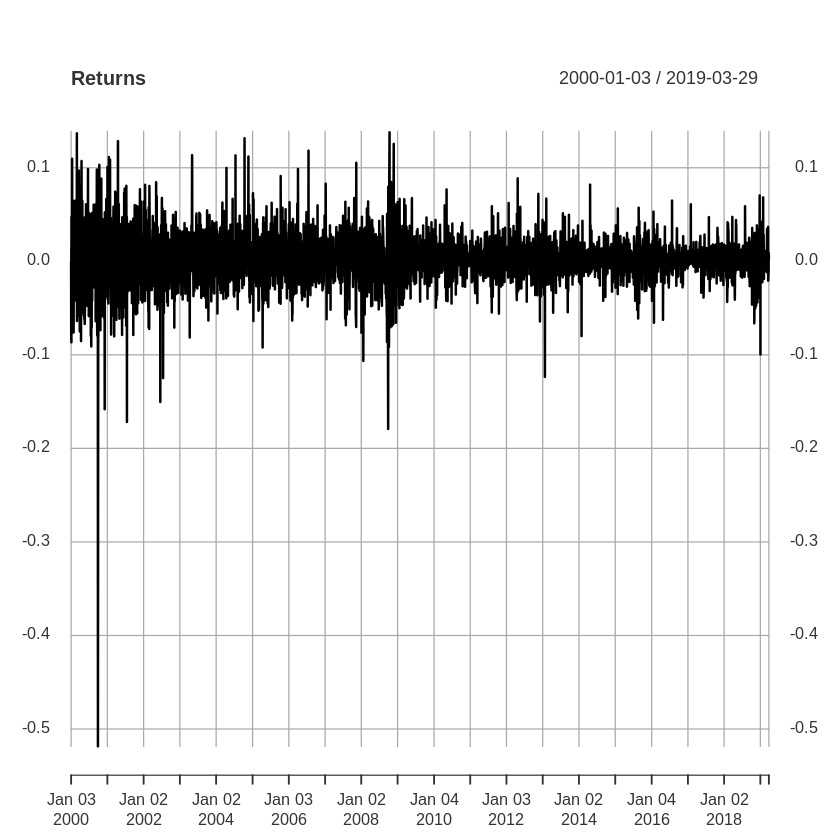

In [495]:
# Plotting returns
Price = as.xts(AAPL$AAPL.Adjusted)
names(Price) = c("price")
Returns = dailyReturn(Price)
plot(Returns)

In [353]:
# Basic normality test on the returns
returnsDf = as.data.frame(Returns)$daily.returns
shapiro.test(returnsDf)
skewness(returnsDf)
kurtosis(returnsDf)


	Shapiro-Wilk normality test

data:  returnsDf
W = 0.89249, p-value < 2.2e-16


[1] -1.628129

[1] 40.72374

In [354]:
# Stationary test on returns
adf.test(Returns)

Warning message in adf.test(Returns):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  Returns
Dickey-Fuller = -15.572, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


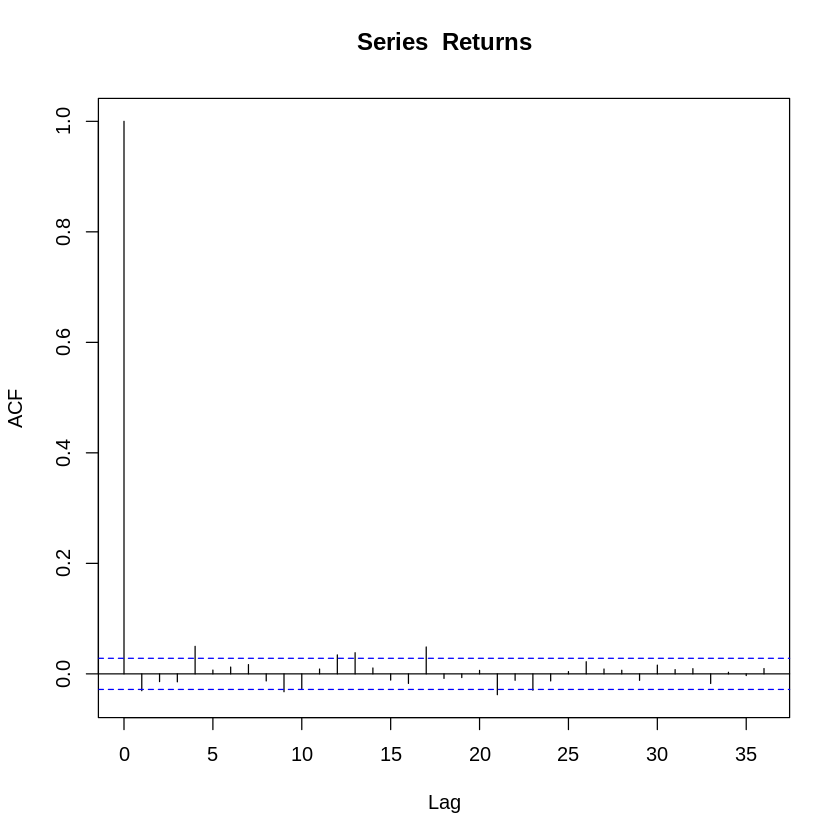

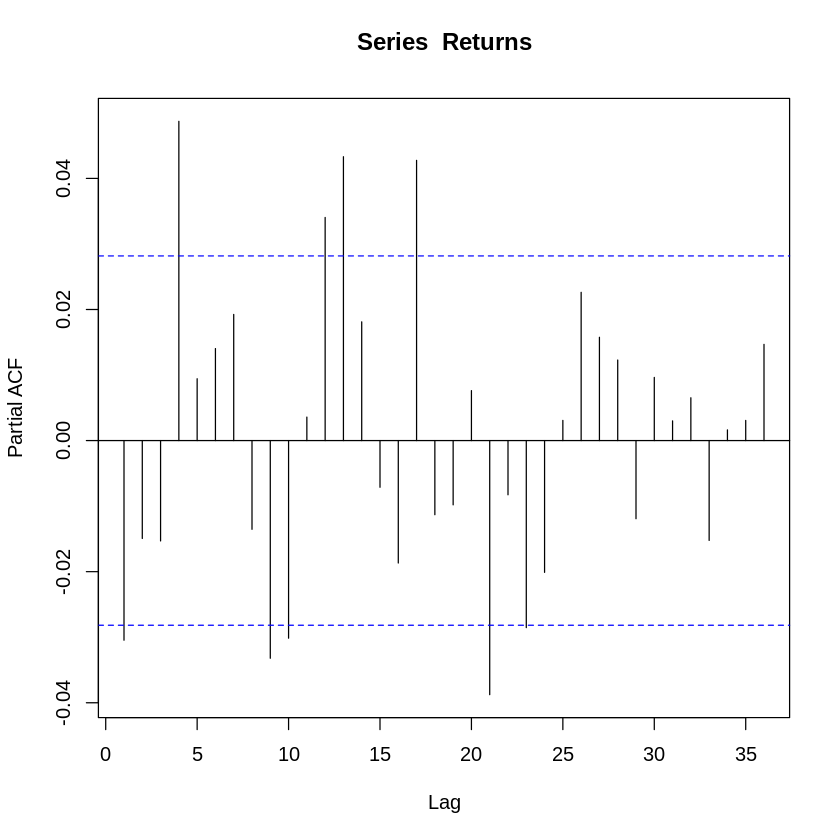

In [473]:
# Examining the ACF & PACF of returns
acf(Returns)
pacf(Returns)

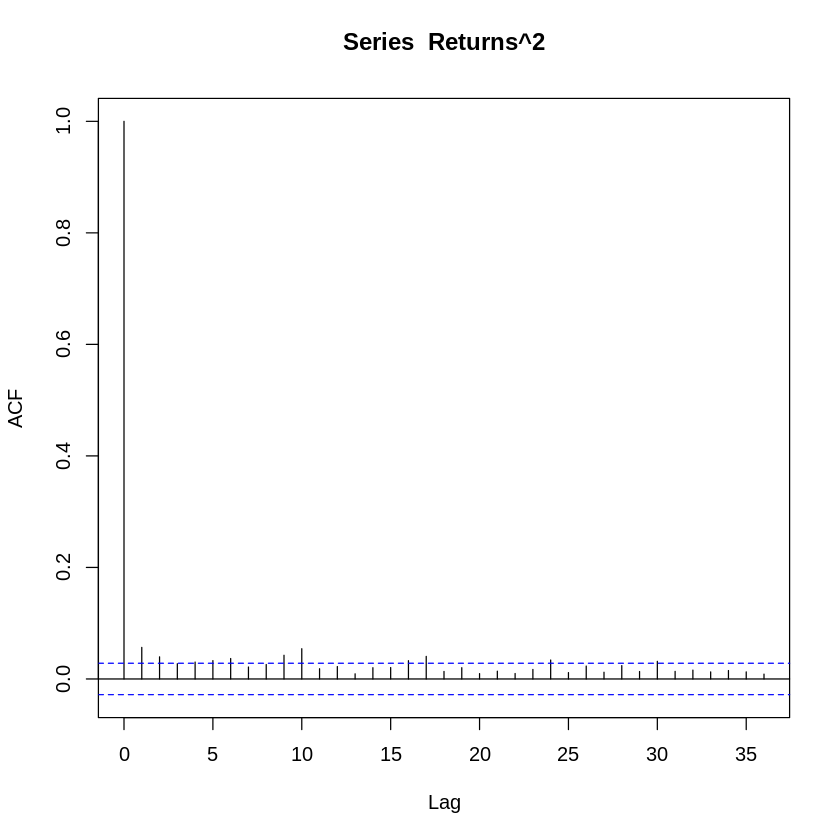

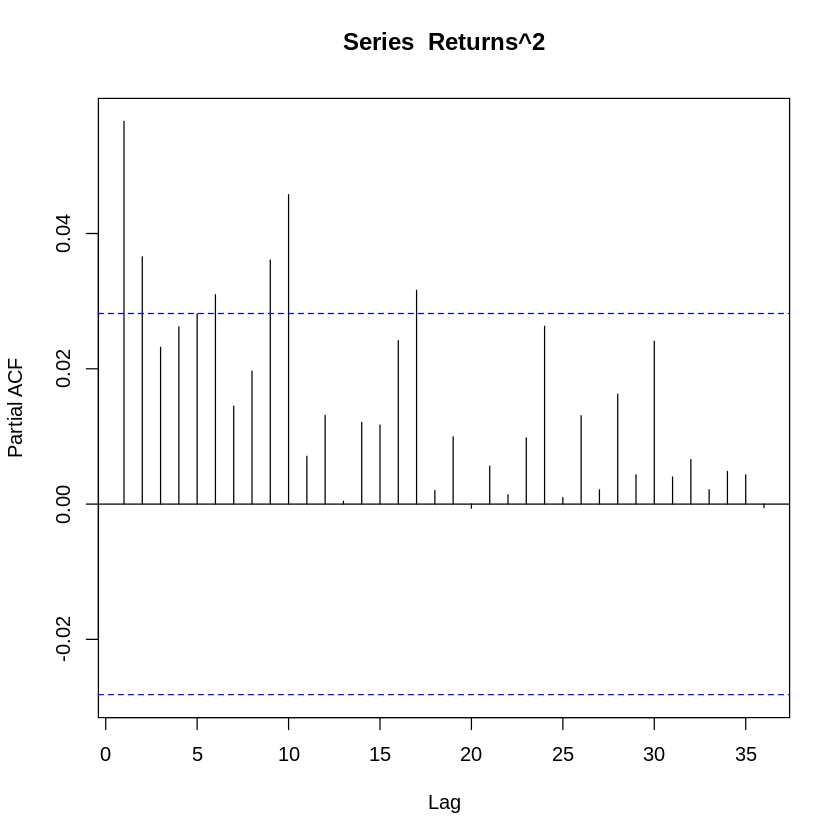

In [474]:
# Examining the ACF & PACF of returns^2
acf(Returns^2)
pacf(Returns^2)

## Intuitions

Looking at the ADF test we can see that the daily return is stationary. 

The normality test shows skews and kurtosis. The negative skew of the returns may suggest that negative news impact the innovation of the series more than positive news. This may suggest the need for asymmetric GARCH models. 

The ACF & PACF of the series suggests possibility of AR model. We will investigate the impact of AR terms on the GARCH model.

The ACF & PACF of the series suggests possibility of MA terms for the GARCH mode. We will investigate the impact of additional MA terms on the GARCH model.

## GARCH Model

Since the returns is stationary, we will model the volatility with the simplest GARCH(1,1) model first to compare against other models. 

In [357]:
spec_garch_11 = ugarchspec(mean.model = list(armaOrder = c(0,0)))
show(spec_garch_11)


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [383]:
fit_garch_11 = ugarchfit(spec_garch_11, Returns, solver='hybrid', out.sample = 30)

In [384]:
show(fit_garch_11)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001957    0.000275   7.1239 0.000000
omega   0.000006    0.000002   2.8611 0.004221
alpha1  0.070646    0.009108   7.7565 0.000000
beta1   0.923010    0.010445  88.3689 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001957    0.000291  6.71943 0.000000
omega   0.000006    0.000007  0.79615 0.425947
alpha1  0.070646    0.032051  2.20413 0.027515
beta1   0.923010    0.035988 25.64783 0.000000

LogLikelihood : 11538.93 

Information Criteria
------------------------------------
                    
Akaike       -4.7962
Bayes        -4.7908
Shibata      -4.7962
Hannan-Quinn -4.7943

Weig

## Asymmetric GARCH

Noted earlier, we will want to explore the impact of asymmetry on the GARCH model due to the difference in the impact of positive and negative news to the returns process. We will start with the TGARCH model.

### TGARCH

In [470]:
spec_tgarch_11 = ugarchspec(
    variance.model = list( model = "fGARCH", submodel = "TGARCH", garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0))
)
spec_tgarch_11


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: fGARCH(1,1)
fGARCH Sub-Model	: TGARCH
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 


In [471]:
fit_tgarch_11 = ugarchfit(spec_tgarch_11, Returns, solver='hybrid', out.sample = 30)
fit_tgarch_11


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: fGARCH(1,1)
fGARCH Sub-Model	: TGARCH
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001607    0.000260   6.1896        0
omega   0.000420    0.000076   5.5067        0
alpha1  0.095212    0.009311  10.2257        0
beta1   0.911350    0.009377  97.1886        0
eta11   0.372888    0.048901   7.6254        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001607    0.000313   5.1312 0.000000
omega   0.000420    0.000164   2.5588 0.010503
alpha1  0.095212    0.027032   3.5222 0.000428
beta1   0.911350    0.024959  36.5139 0.000000
eta11   0.372888    0.075080   4.9665 0.000001

LogLikelihood : 11589.88 

Information Criteria
---------------------------


please wait...calculating quantiles...


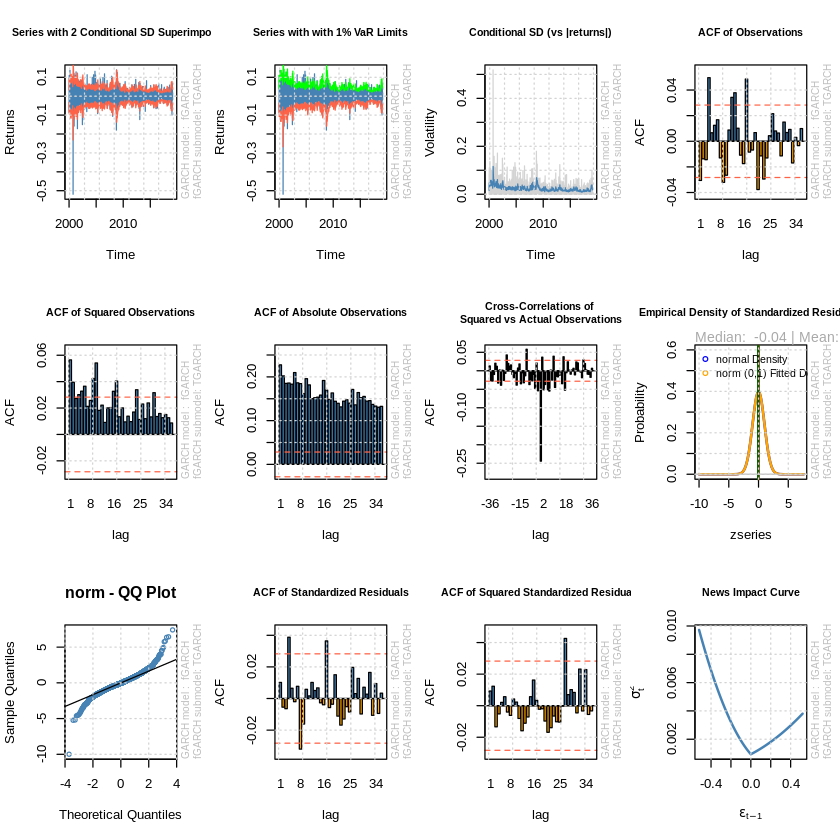

In [434]:
plot(fit_tgarch_11, which = "all")

We can observe that providing asymmetry to the model improves the model's performance. With that, we can explore if the asymmetry is a result of conditional variance with the EGARCH model.

### EGARCH

In [468]:
spec_egarch_11 = ugarchspec(mean.model = list(armaOrder = c(0,0)), variance.model= list(garchOrder = c(1,1), model="eGARCH"))
show(spec_egarch_11)


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: eGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [469]:
fit_egarch_11 = ugarchfit(spec_egarch_11, Returns, solver='hybrid', out.sample = 30)
fit_egarch_11


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001671    0.000320   5.2216        0
omega  -0.117904    0.010479 -11.2514        0
alpha1 -0.056031    0.007641  -7.3326        0
beta1   0.983375    0.001327 740.8497        0
gamma1  0.157625    0.013045  12.0832        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001671    0.000542   3.0844 0.002040
omega  -0.117904    0.029518  -3.9944 0.000065
alpha1 -0.056031    0.013044  -4.2954 0.000017
beta1   0.983375    0.003409 288.4905 0.000000
gamma1  0.157625    0.048721   3.2353 0.001215

LogLikelihood : 11591.07 

Information Criteria
------------------------------------
                

We can see the EGARCH(1,1) model performed better than the other models but it is still failing at Ljung-box test for the square residuals. We will attempt to increase the MA term for the EGARCH model to account for the serial correlation of the square of residuals.

### EGARCH(1,2)

In [487]:
spec_egarch_12 = ugarchspec(mean.model = list(armaOrder = c(0,0)), variance.model= list(garchOrder = c(1,2), model="eGARCH"))
show(spec_egarch_12)


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: eGARCH(1,2)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [488]:
fit_egarch_12 = ugarchfit(spec_egarch_12, Returns, solver='hybrid', out.sample = 30)
fit_egarch_12


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001672    0.000292   5.7192        0
omega  -0.127462    0.021907  -5.8182        0
alpha1 -0.061576    0.006700  -9.1906        0
beta1   0.776043    0.001656 468.6130        0
beta2   0.205902    0.001889 109.0295        0
gamma1  0.181361    0.015097  12.0127        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001672    0.000407   4.1102 0.000040
omega  -0.127462    0.074786  -1.7044 0.088314
alpha1 -0.061576    0.016251  -3.7891 0.000151
beta1   0.776043    0.005435 142.7765 0.000000
beta2   0.205902    0.004964  41.4828 0.000000
gamma1  0.181361    0.035165   5.1574 0.000000

LogLike


please wait...calculating quantiles...


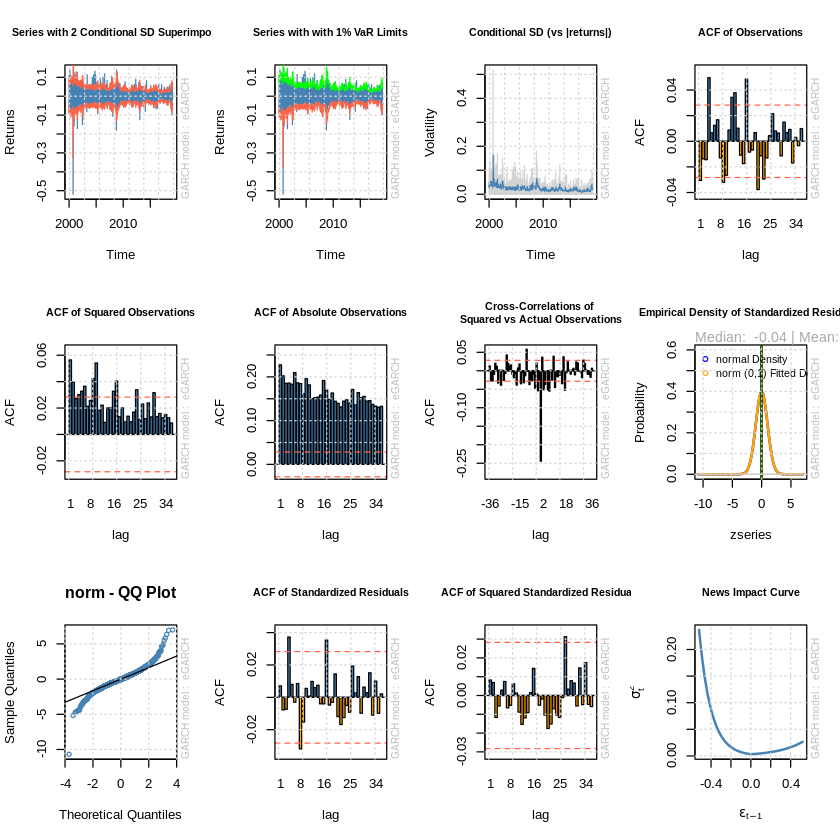

In [489]:
plot(fit_egarch_12, which="all")

## Other Models

### ARCH

In [466]:
spec_garch_10 = ugarchspec(mean.model = list(armaOrder = c(0,0)), variance.model= list(garchOrder = c(1,0)))
show(spec_garch_10)


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,0)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [467]:
fit_garch_10 = ugarchfit(spec_garch_10, Returns, solver='hybrid', out.sample = 30)
fit_garch_10


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.119601    0.000040 2974.594        0
omega   0.000007    0.000001   10.727        0
alpha1  0.999000    0.000451 2213.723        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.119601    0.000438 272.7793  0.00000
omega   0.000007    0.000006   1.1816  0.23736
alpha1  0.999000    0.004535 220.2867  0.00000

LogLikelihood : 1575.533 

Information Criteria
------------------------------------
                     
Akaike       -0.65386
Bayes        -0.64982
Shibata      -0.65386
Hannan-Quinn -0.65244

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
      

### GARCH-M

In [464]:
spec_garchm_11 = ugarchspec(mean.model = list(armaOrder = c(0,0), archm = TRUE, archpow = 1))
show(spec_garchm_11)


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(0,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: TRUE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [465]:
fitt = ugarchfit(spec_garchm_11, Returns, solver='hybrid', out.sample = 30)
fitt


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002073    0.000881  2.35274 0.018636
archm  -0.006323    0.045476 -0.13903 0.889422
omega   0.000006    0.000002  2.75707 0.005832
alpha1  0.070454    0.009256  7.61133 0.000000
beta1   0.923156    0.010748 85.89406 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.002073    0.001043  1.98751 0.046866
archm  -0.006323    0.053571 -0.11803 0.906046
omega   0.000006    0.000008  0.76041 0.447012
alpha1  0.070454    0.032656  2.15746 0.030970
beta1   0.923156    0.037283 24.76053 0.000000

LogLikelihood : 11538.94 

Information Criteria
------------------------------------
                

### IGARCH

The IGARCH model will be unsuitable for forecasting the returns process as the process is already stationary and does not benefit from futher integration.

### ARMA(1,0)-GARCH(1,1)

In [479]:
spec_arma_10_garch_11 = ugarchspec(mean.model = list(armaOrder = c(1,0)))
show(spec_arma_10_garch_11)


*---------------------------------*
*       GARCH Model Spec          *
*---------------------------------*

Conditional Variance Dynamics 	
------------------------------------
GARCH Model		: sGARCH(1,1)
Variance Targeting	: FALSE 

Conditional Mean Dynamics
------------------------------------
Mean Model		: ARFIMA(1,0,0)
Include Mean		: TRUE 
GARCH-in-Mean		: FALSE 

Conditional Distribution
------------------------------------
Distribution	:  norm 
Includes Skew	:  FALSE 
Includes Shape	:  FALSE 
Includes Lambda	:  FALSE 



In [480]:
fit_arma_10_garch_11 = ugarchfit(spec_arma_10_garch_11, Returns, solver='hybrid', out.sample = 30)
show(fit_arma_10_garch_11)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.001958    0.000275  7.125310 0.000000
ar1    -0.000214    0.015543 -0.013791 0.988997
omega   0.000006    0.000002  2.821438 0.004781
alpha1  0.070379    0.009165  7.678730 0.000000
beta1   0.923267    0.010546 87.547567 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.001958    0.000291  6.717125 0.000000
ar1    -0.000214    0.014478 -0.014805 0.988188
omega   0.000006    0.000007  0.774343 0.438728
alpha1  0.070379    0.032616  2.157831 0.030941
beta1   0.923267    0.036875 25.037722 0.000000

LogLikelihood : 11538.93 

Information Criteria
------------------------------------
    

## Summary

### Comparison of Viable Models


Model | Log Likelihood | AIC
--- | --- | ---
ARCH(1) | 1575.533 | -0.65386
GARCH(1,1) | 11538.93 | -4.7962
ARMA(1,0)-GARCH(1,1) | 11538.93 | -4.7962
TGARCH(1,1) | 11589.88 | -4.8170
EGARCH(1,1) | 11591.07 | -4.8175
EGARCH(1,2) | 11593.1 | -4.8179
GARCH-M(1,1) | 11538.94 | -4.7958



Comparing the different models, we can see that the asymmetric GARCH model, EGARCH(1,2), appears to be the best model for AAPL daily returns, matching our initial intuition that negative news impact the returns more significantly than positive news. 

The EGARCH(1,2) model's coefficients, mu, omega, alpha1, beta1, beta2 & gamma1 are all significant. It also shows 

We can also observe that adding AR terms to the model does not improve the model. This can be seen from the ARMA(1,0)-GARCH(1,1) model where the coefficient of the ar1 term is tested to be insignificant. 

In [ ]:
## Forecasting with EGARCH(1,2)

In [490]:
forecast_egarch_12 = ugarchforecast(fit_egarch_12, n.ahead=15, n.roll=5)
forecast_egarch_12


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: eGARCH
Horizon: 15
Roll Steps: 5
Out of Sample: 15

0-roll forecast [T0=2019-02-14]:
       Series   Sigma
T+1  0.001672 0.01880
T+2  0.001672 0.01917
T+3  0.001672 0.01924
T+4  0.001672 0.01937
T+5  0.001672 0.01949
T+6  0.001672 0.01961
T+7  0.001672 0.01972
T+8  0.001672 0.01984
T+9  0.001672 0.01996
T+10 0.001672 0.02007
T+11 0.001672 0.02019
T+12 0.001672 0.02030
T+13 0.001672 0.02041
T+14 0.001672 0.02052
T+15 0.001672 0.02063



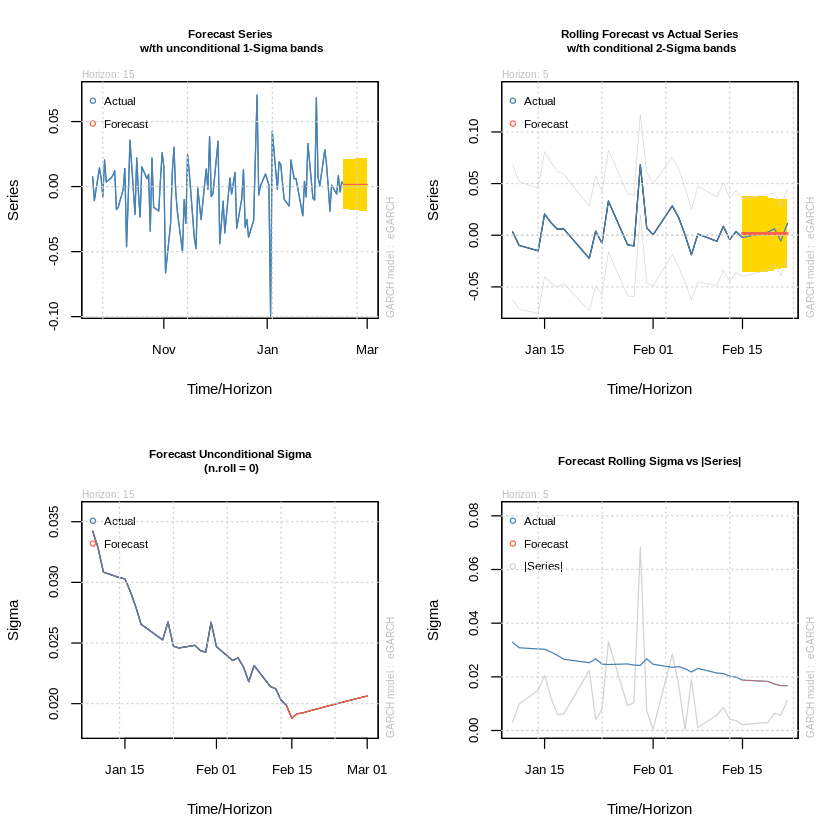

In [492]:
plot(forecast_egarch_12, which="all")

In [ ]:

Using EGARCH(1,2) to forecast we get the next period daily return to be 0.001672.

The chart of the forecast is as followed:

### References
https://bookdown.org/wfoote01/faur/meauring-volatility.html
https://cran.r-project.org/web/packages/rugarch/rugarch.pdf
https://cran.r-project.org/web/packages/rugarch/vignettes/Introduction_to_the_rugarch_package.pdf
http://faculty.chicagobooth.edu/ruey.tsay/teaching/bs41202/sp2015/IntroPackages.pdf
http://www.unstarched.net/2014/01/02/the-realized-garch-model/
http://r.789695.n4.nabble.com/Interpretation-of-sign-bias-test-in-rugarch-output-td4667502.html